In [16]:
import numpy as np
import jax
import jax.numpy as jnp
import dataclasses
from itertools import product

# -------------------- Mesh and Solver Definitions --------------------

Array = jax.Array

@dataclasses.dataclass
class Mesh:
    xs: Array; dx: float
    vs: Array; dv: float
    X: Array; V: Array
    period_x: float; period_v: float
    nx: int; nv: int

def make_mesh(length_x: float, length_v: float, nx: int, nv: int) -> Mesh:
    xs = jnp.linspace(0., length_x, nx, endpoint=False)
    dx = xs[1] - xs[0]
    vs = jnp.linspace(-length_v, length_v, nv, endpoint=False)
    dv = vs[1] - vs[0]
    V, X = jnp.meshgrid(vs, xs)
    return Mesh(xs, dx, vs, dv, X, V, length_x, length_v, nx, nv)

@dataclasses.dataclass(frozen=True)
class VlasovPoissonSolver:
    mesh: Mesh
    dt: float
    f_eq: Array

    def semilag_x(self, f: Array) -> Array:
        out = jnp.zeros_like(f)
        for i, v in enumerate(self.mesh.vs):
            out = out.at[:, i].set(
                jnp.interp(self.mesh.xs - 0.5*v*self.dt,
                           self.mesh.xs, f[:, i],
                           period=self.mesh.period_x))
        return out

    def build_semilag_x(self):
        def interp_jax_x(f_col, v):
            return jnp.interp(self.mesh.xs - 0.5*v*self.dt,
                              self.mesh.xs, f_col,
                              period=self.mesh.period_x)
        return lambda f: jax.vmap(interp_jax_x, in_axes=(1,0), out_axes=1)(f, self.mesh.vs)

    def build_semilag_v(self):
        def interp_jax_v(f_row, E_val):
            return jnp.interp(self.mesh.vs - E_val*self.dt,
                              self.mesh.vs, f_row,
                              period=2*self.mesh.period_v)
        return jax.vmap(interp_jax_v, in_axes=(0,0), out_axes=0)

    def compute_rho(self, f: Array) -> Array:
        return self.mesh.dv * jnp.sum(self.f_eq - f, axis=1)

    def compute_E_from_rho(self, rho: Array) -> Array:
        rho_hat = jnp.fft.fft(rho)
        freqs   = jnp.fft.fftfreq(self.mesh.nx, d=self.mesh.period_x/self.mesh.nx)
        E_hat   = jnp.zeros_like(rho_hat)
        inv     = -1.0/(1j*2*jnp.pi*freqs[1:])
        E_hat   = E_hat.at[1:].set(inv * rho_hat[1:])
        return jnp.real(jnp.fft.ifft(E_hat))

    def compute_E(self, f: Array) -> Array:
        return self.compute_E_from_rho(self.compute_rho(f))

    def compute_electric_energy(self, E: Array) -> Array:
        return 0.5 * jnp.sum(E**2) * self.mesh.dx

    def run_forward_jax_scan(self, f_init: Array, H: Array, t_final: float):
        num_steps = int(t_final / self.dt)
        tspan     = self.dt * jnp.arange(num_steps)

        semilag_x = self.build_semilag_x()
        semilag_v = self.build_semilag_v()
        compute_E  = jax.jit(self.compute_E)
        compute_ee = jax.jit(self.compute_electric_energy)

        def step(f, _):
            f_half = semilag_x(f)
            E      = compute_E(f_half) + H
            ee     = compute_ee(E)
            f_next = semilag_v(f_half, E)
            f_next = semilag_x(f_next)
            return f_next, (f_next, E, ee)

        _, (F_hist, E_hist, ee_hist) = jax.lax.scan(jax.jit(step), f_init, tspan)

        # prepend t=0
        F_full = jnp.concatenate([f_init[None], F_hist], axis=0)
        E0 = compute_E(semilag_x(f_init))
        ee0 = compute_ee(E0)
        E_full = jnp.concatenate([E0[None], E_hist], axis=0)
        ee_full= jnp.concatenate([ee0[None], ee_hist], axis=0)
        return F_full, E_full, ee_full

# -------------------- Problem Setup --------------------

nx, nv  = 256, 256
dt      = 0.1
t_final = 30.0

mesh   = make_mesh(10*jnp.pi, 6.0, nx, nv)
alpha, mu1, mu2 = 0.5, 2.4, -2.4
f_eq   = (alpha*jnp.exp(-0.5*(mesh.V-mu1)**2) +
          (1-alpha)*jnp.exp(-0.5*(mesh.V-mu2)**2)) / jnp.sqrt(2*jnp.pi)

epsilon, k0 = 0.001, 0.2
f_iv        = (1.0 + epsilon*jnp.cos(k0*mesh.X)) * f_eq

solver = VlasovPoissonSolver(mesh, dt, f_eq)

# JIT‐compile forward scan wrapper
@jax.jit
def solver_forward(f_init: Array, H: Array):
    return solver.run_forward_jax_scan(f_init, H, t_final)

# -------------------- Helper Functions --------------------

def compute_external_field(xs, a1, a2, k=1):
    L = mesh.period_x
    return a1*jnp.sin(2*jnp.pi*k*xs/L) + a2*jnp.sin(4*jnp.pi*k*xs/L)

def compute_KL_divergence(f1, f2):
    p = f1 / jnp.sum(f1)
    q = f2 / jnp.sum(f2)
    eps = 1e-10
    return jnp.sum(p * jnp.log(jnp.clip(p, eps, None) / jnp.clip(q, eps, None)))

def create_matrix(entries, p1_vals, p2_vals):
    M = np.zeros((len(p1_vals), len(p2_vals)))
    for val, a1, a2 in entries:
        i = np.where(p1_vals==a1)[0][0]
        j = np.where(p2_vals==a2)[0][0]
        M[i,j] = val
    return M


# -------------------- Parameter Grid & Tracking --------------------

a_k1_values = np.arange(-0.1, 0.1001, 0.001)
a_k2_values = np.arange(-0.1, 0.1001, 0.001)

best_ti_L2      = np.inf; best_L2_params    = (None,None)
best_ti_KL2     = np.inf; best_KL2_params   = (None,None)
best_final_E    = np.inf; best_E_params     = (None,None)
best_ti_EE      = np.inf; best_EE_params    = (None,None)
# **new** best‐trackers for ρ‑metrics:
best_rho_L2     = np.inf; best_rho_params   = (None,None)
best_ti_rho_L2  = np.inf; best_ti_rho_params= (None,None)

ti_L2_list      = []
ti_KL2_list     = []
final_E_list    = []
ti_EE_list      = []
# **new** storage lists:
rho_L2_list     = []
ti_rho_L2_list  = []

for idx, (a1, a2) in enumerate(product(a_k1_values, a_k2_values)):
    H = compute_external_field(mesh.xs, a1, a2)
    F_arr, E_arr, ee_arr = solver_forward(f_iv, H)

    # 1) ∫ |f-f_eq|² dxdv dt
    ti_L2 = float(jnp.sum((F_arr - f_eq)**2) * dt)
    ti_L2_list.append((ti_L2, a1, a2))
    if ti_L2 < best_ti_L2:
        best_ti_L2, best_L2_params = ti_L2, (a1, a2)
        print(f"New best ∫L2: {ti_L2:.3e} at a1={a1}, a2={a2}")

    # 2) ∫ KL² dt
    kl_ts = jax.vmap(lambda f: compute_KL_divergence(f, f_eq))(F_arr)
    ti_KL2 = float(jnp.sum(kl_ts**2) * dt)
    ti_KL2_list.append((ti_KL2, a1, a2))
    if ti_KL2 < best_ti_KL2:
        best_ti_KL2, best_KL2_params = ti_KL2, (a1, a2)
        print(f"New best ∫KL²: {ti_KL2:.3e} at a1={a1}, a2={a2}")

    # 3) Final electric energy
    final_E = float(ee_arr[-1])
    final_E_list.append((final_E, a1, a2))
    if final_E < best_final_E:
        best_final_E, best_E_params = final_E, (a1, a2)
        print(f"New best final E: {final_E:.3e} at a1={a1}, a2={a2}")

    # 4) ∫ electric energy dt
    ti_EE = float(jnp.sum(ee_arr) * dt)
    ti_EE_list.append((ti_EE, a1, a2))
    if ti_EE < best_ti_EE:
        best_ti_EE, best_EE_params = ti_EE, (a1, a2)
        print(f"New best ∫ElectricE: {ti_EE:.3e} at a1={a1}, a2={a2}")

    # --- here come the two new ρ‑objectives ---
    # build ρ(t,x)
    rho_ts = mesh.dv * jnp.sum(F_arr, axis=1)        # shape (T+1, nx)
    rho0 = rho_ts[0]
    rhoT = rho_ts[-1]

    # 5) final-frame L2 between ρ(T) and ρ(0)
    rho_L2 = float(jnp.sum((rhoT - rho0)**2) * mesh.dx)
    rho_L2_list.append((rho_L2, a1, a2))
    if rho_L2 < best_rho_L2:
        best_rho_L2, best_rho_params = rho_L2, (a1, a2)
        print(f"New best final ρ L2: {rho_L2:.3e} at a1={a1}, a2={a2}")

    # 6) time-integral ∫‖ρ(t)-ρ(0)‖² dt
    ti_rho_L2 = float(jnp.sum((rho_ts - rho0)**2) * mesh.dx * dt)
    ti_rho_L2_list.append((ti_rho_L2, a1, a2))
    if ti_rho_L2 < best_ti_rho_L2:
        best_ti_rho_L2, best_ti_rho_params = ti_rho_L2, (a1, a2)
        print(f"New best ∫ρ L2 dt: {ti_rho_L2:.3e} at a1={a1}, a2={a2}")
    # ---------------------------------------------------

    if idx % 100 == 0:
        print(f"Processed {idx}/{len(a_k1_values)*len(a_k2_values)}")

# -------------------- Build & Save Landscapes --------------------

ti_L2_mat   = create_matrix(ti_L2_list,    a_k1_values, a_k2_values)
ti_KL2_mat  = create_matrix(ti_KL2_list,   a_k1_values, a_k2_values)
final_E_mat = create_matrix(final_E_list,  a_k1_values, a_k2_values)
ti_EE_mat   = create_matrix(ti_EE_list,    a_k1_values, a_k2_values)
rho_L2_mat  = create_matrix(rho_L2_list,   a_k1_values, a_k2_values)      # **new**
ti_rho_L2_mat = create_matrix(ti_rho_L2_list, a_k1_values, a_k2_values)   # **new**

np.savez("time_integral_L2_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         ti_L2_matrix=ti_L2_mat,
         t_final=t_final)
np.savez("time_integral_KL2_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         ti_KL2_matrix=ti_KL2_mat,
         t_final=t_final)
np.savez("final_electric_energy_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         fe_matrix=final_E_mat,
         t_final=t_final)
np.savez("time_integral_ee_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         ti_ee_matrix=ti_EE_mat,
         t_final=t_final)

# **new** saves for rho metrics
np.savez("final_rho_L2_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         rho_L2_matrix=rho_L2_mat,
         t_final=t_final)
np.savez("time_integral_rho_L2_data.npz",
         a_k1_values=a_k1_values,
         a_k2_values=a_k2_values,
         ti_rho_L2_matrix=ti_rho_L2_mat,
         t_final=t_final)

print("All landscapes saved to .npz files.")


New best ∫L2: 1.732e+03 at a1=-0.1, a2=-0.1
New best ∫KL²: 1.583e-01 at a1=-0.1, a2=-0.1
New best final E: 1.332e+00 at a1=-0.1, a2=-0.1
New best ∫ElectricE: 3.489e+01 at a1=-0.1, a2=-0.1
New best final ρ L2: 1.627e+00 at a1=-0.1, a2=-0.1
New best ∫ρ L2 dt: 2.930e+01 at a1=-0.1, a2=-0.1
Processed 0/40401
New best ∫L2: 1.727e+03 at a1=-0.1, a2=-0.099
New best ∫KL²: 1.575e-01 at a1=-0.1, a2=-0.099
New best final E: 1.325e+00 at a1=-0.1, a2=-0.099
New best ∫ElectricE: 3.469e+01 at a1=-0.1, a2=-0.099
New best final ρ L2: 1.621e+00 at a1=-0.1, a2=-0.099
New best ∫ρ L2 dt: 2.912e+01 at a1=-0.1, a2=-0.099
New best ∫L2: 1.723e+03 at a1=-0.1, a2=-0.098
New best ∫KL²: 1.567e-01 at a1=-0.1, a2=-0.098
New best final E: 1.318e+00 at a1=-0.1, a2=-0.098
New best ∫ElectricE: 3.449e+01 at a1=-0.1, a2=-0.098
New best final ρ L2: 1.615e+00 at a1=-0.1, a2=-0.098
New best ∫ρ L2 dt: 2.894e+01 at a1=-0.1, a2=-0.098
New best ∫L2: 1.719e+03 at a1=-0.1, a2=-0.097
New best ∫KL²: 1.559e-01 at a1=-0.1, a2=-0.097
N

KeyboardInterrupt: 

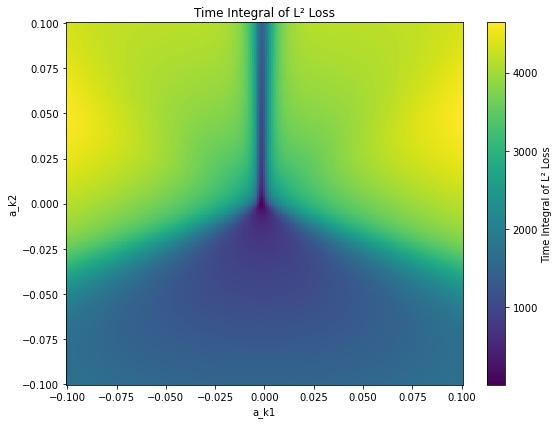

Saved: time_integral_L2_landscape.png


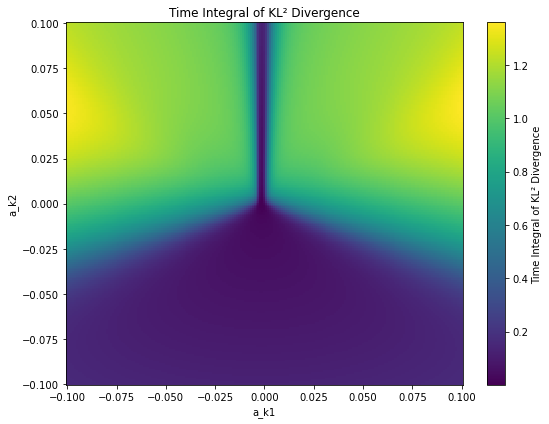

Saved: time_integral_KL2_landscape.png


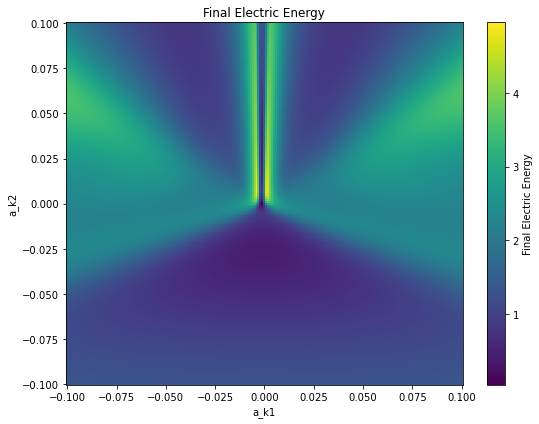

Saved: final_electric_energy_landscape.png


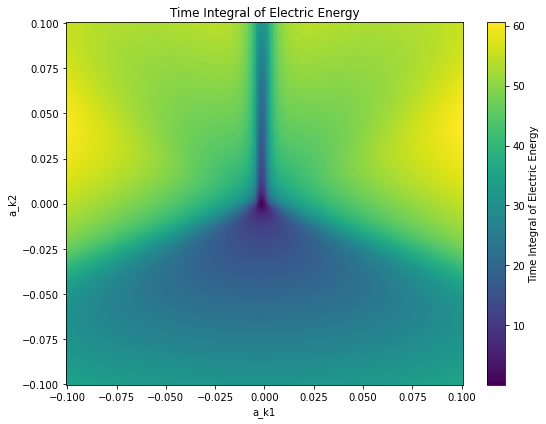

Saved: time_integral_ee_landscape.png


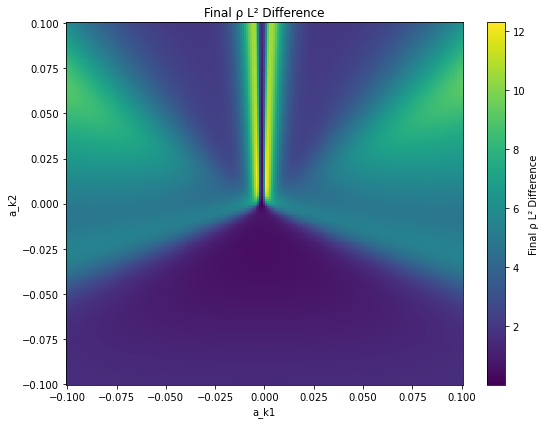

Saved: final_rho_L2_landscape.png


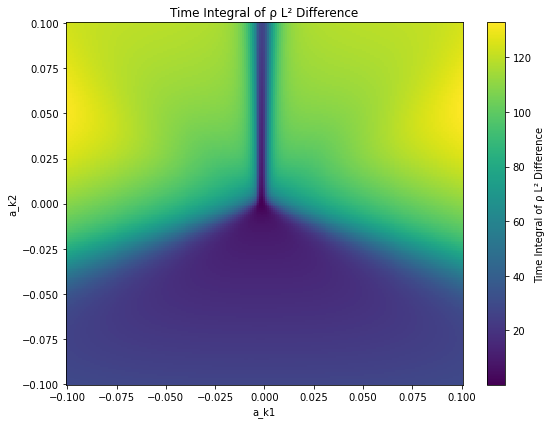

Saved: time_integral_rho_L2_landscape.png


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def load_and_plot(filename, matrix_key, xlabel, ylabel, title, output_png):
    """
    Load a .npz file containing a landscape matrix and plot it.

    Parameters:
      filename     : str, path to the .npz file
      matrix_key   : str, key of the matrix inside the .npz
      xlabel       : str, label for the x-axis
      ylabel       : str, label for the y-axis
      title        : str, plot title (and colorbar label)
      output_png   : str, path to save the resulting .png
    """
    data = np.load(filename)
    a_k1 = data['a_k1_values']
    a_k2 = data['a_k2_values']
    matrix = data[matrix_key]

    # Create meshgrid for plotting (a_k1 as x, a_k2 as y)
    A_k1, A_k2 = np.meshgrid(a_k1, a_k2)

    fig, ax = plt.subplots(figsize=(8, 6))
    c = ax.pcolormesh(A_k1, A_k2, matrix.T, shading='auto', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.colorbar(c, ax=ax, label=title)
    plt.tight_layout()
    plt.savefig(output_png, dpi=300)
    plt.show()
    print(f"Saved: {output_png}")


# 1. Time integral of L² loss
load_and_plot(
    filename="time_integral_L2_data.npz",
    matrix_key="ti_L2_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Time Integral of L² Loss",
    output_png="time_integral_L2_landscape.png"
)

# 2. Time integral of squared KL divergence
load_and_plot(
    filename="time_integral_KL2_data.npz",
    matrix_key="ti_KL2_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Time Integral of KL² Divergence",
    output_png="time_integral_KL2_landscape.png"
)

# 3. Final electric energy
load_and_plot(
    filename="final_electric_energy_data.npz",
    matrix_key="fe_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Final Electric Energy",
    output_png="final_electric_energy_landscape.png"
)

# 4. Time integral of electric energy
load_and_plot(
    filename="time_integral_ee_data.npz",
    matrix_key="ti_ee_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Time Integral of Electric Energy",
    output_png="time_integral_ee_landscape.png"
)

# 5. Final ρ L² difference (ρ(T) vs ρ(0))
load_and_plot(
    filename="final_rho_L2_data.npz",
    matrix_key="rho_L2_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Final ρ L² Difference",
    output_png="final_rho_L2_landscape.png"
)

# 6. Time integral of ρ L² difference
load_and_plot(
    filename="time_integral_rho_L2_data.npz",
    matrix_key="ti_rho_L2_matrix",
    xlabel="a_k1",
    ylabel="a_k2",
    title="Time Integral of ρ L² Difference",
    output_png="time_integral_rho_L2_landscape.png"
)
